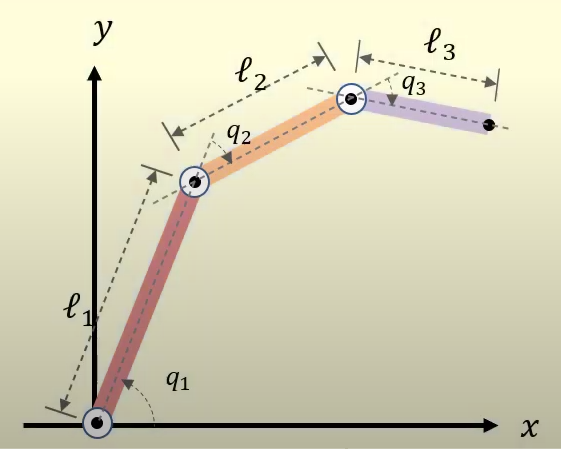

# I. Kinematics

Joint variables: $\ \textbf{q} = \begin{bmatrix} q_1 \\ q_2 \\ q_3\end{bmatrix}$
 
End-effector's configuration: $\ \textbf{x} = \begin{bmatrix} x_e \\ y_e \\ \phi \end{bmatrix}$

# 1. Forward kinematics $x = \varphi(q)$

Denavit-Hartenberg (DH) parameters:



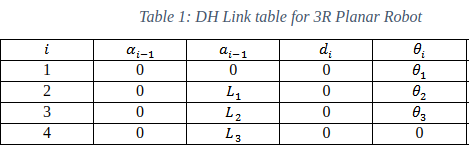

In [1]:
import numpy as np
import sympy as sp


# Transformation matrix
def T(alpha, a, d, θ):
    return np.array(
        [
            [sp.cos(θ), -sp.sin(θ), 0, a],
            [sp.sin(θ) * sp.cos(alpha), sp.cos(θ) * sp.cos(alpha), -sp.sin(alpha), -sp.sin(alpha) * d],
            [sp.sin(θ) * sp.sin(alpha), sp.cos(θ) * sp.sin(alpha), sp.cos(alpha), sp.cos(alpha) * d],
            [0, 0, 0, 1],
        ]
    )

In [5]:
q1, q2, q3, l1, l2, l3 = sp.symbols("q1, q2, q3, l1, l2, l3")

T01 = T(0, 0, 0, q1)
T12 = T(0, l1, 0, q2)
T23 = T(0, l2, 0, q3)
T34 = T(0, l3, 0, 0)

T04 = sp.simplify(T01 @ T12 @ T23 @ T34)
T04

[[cos(q1 + q2 + q3), -sin(q1 + q2 + q3), 0, d1*cos(q1) + d2*cos(q1 + q2) + d3*cos(q1 + q2 + q3)], [sin(q1 + q2 + q3), cos(q1 + q2 + q3), 0, d1*sin(q1) + d2*sin(q1 + q2) + d3*sin(q1 + q2 + q3)], [0, 0, 1, 0], [0, 0, 0, 1]]

The coordinates of the end-effector:

$$x_e = l_1 \cos{q_1} + l_2 \cos{(q_1 + q_2)} + l_3 \cos{(q_1 + q_2 + q_3)}$$

$$y_e = l_1 \sin{q_1} + l_2 \sin{(q_1 + q_2)} + l_3 \sin{(q_1 + q_2 + q_3)}$$

The orientation of the end-effector:

$$\phi = q_1 + q_2 + q_3$$

In [ ]:
def FK(θ1, θ2, θ3, d1, d2, d3):
    x_e = (T04[0][3].subs({l1: d1, l2: d2, l3: d3, q1: np.radians(θ1), q2: np.radians(θ2), q3: np.radians(θ3)}).simplify())
    y_e = (T04[0][3].subs({l1: d1, l2: d2, l3: d3, q1: np.radians(θ1), q2: np.radians(θ2), q3: np.radians(θ3)}).simplify())
    phi = int(θ1 + θ2 + θ3)

    return round(x_e, 3), round(y_e, 3), phi

In [26]:
FK(30, 30, 30, 1, 1, 1)

(1.366, 2.366)

----------------------
# 2. Inverse kinematics $q = \varphi^{-1}(x)$

End-effector pose is given by $\ (x_e,\ y_e,\ \phi)$.

The 3-rd joint pose is as follows $\ (x_3,\ y_3,\ \phi)$, where

$$x_3 = x_e - l_3 \cos{\phi}$$
$$y_3 = y_e - l_3 \sin{\phi}$$

Once the 3-rd joint pose is known, we can apply formulas of 2R planar manipulator:

$$q_1 = \arctan{(\frac{y_3}{x_3})}\ \mp \arctan{(\frac{l_2 \sin{q_2}}{l_1 + l_2 \cos{q_2}})}$$

$$q_2 = \pm \arccos{(\frac{x_3^2 + y_3^2 - l_1^2 - l_2^2}{2l_1 l_2})}$$

Since $\phi = q_1 + q_2 + q_3$, then 

$$q_3 = \phi - q_1 - q_2$$

In [19]:
def IK(x_e, y_e, phi, l1, l2, l3):
    x3 = x_e - l3 * np.cos(np.radians(phi))
    y3 = y_e - l3 * np.sin(np.radians(phi))

    th2 = np.arccos((x3**2 + y3**2 - (l1**2 + l2**2)) / (2 * l1 * l2))
    th1 = np.arctan2(y3, x3) - np.arctan2(l2 * np.sin(th2), l1 + l2 * np.cos(th2))
    th3 = np.radians(phi) - (th1 + th2)

    return round(np.degrees(th1)), round(np.degrees(th2)), round(np.degrees(th3))

In [27]:
IK(1.366, 2.366, 90, 1, 1, 1)

(30, 30, 30)

----------------------
# II. Dynamical model

$$\fbox{$\mathbf{M(q) \ddot{q} + C(q, \dot{q}) \dot{q} + g(q) = \tau}$}$$
where 

$\mathbf{q \in \mathbb{R}^3}$ - vector of joint coordinates

$\mathbf{M(q) \in \mathbb{R}^{3 \times 3}}$ - Inertia matrix (symmetric and positive definite)

$\mathbf{C(q,\dot{q})\dot{q} \in \mathbb{R}^3}$ - vector of Coriolis and centrifugal forces

$\mathbf{g(q) \in \mathbb{R}^3}$ - vector of gravity forces

$\mathbf{\tau \in \mathbb{R}^3}$ - vector of joint torques

----------------------
# 1. Euler-Lagrange formulation
1) Find the kinetic energy $K(\mathbf{q, \dot{q}})$ and the potential energy $P(\mathbf{q})$

2) The Lagrangian:
$$L(\mathbf{q, \dot{q}}) = K(\mathbf{q, \dot{q}}) - P(\mathbf{q}) = \frac{1}{2} \mathbf{\dot{q}^T M(q) \dot{q}} - P(\mathbf{q})$$

3) Use Lagrange's equations:
$$\frac{d}{dt} \left( \frac{\partial{L(\mathbf{q, \dot{q}})}}{\partial{\mathbf{\dot{q}}}} \right) - \frac{\partial{L(\mathbf{q, \dot{q}})}}{\partial{\mathbf{q}}} = \mathbf{\tau}$$

Since
\begin{align*}
    \frac{\partial{L(\mathbf{q, \dot{q}})}}{\partial{\mathbf{\dot{q}}}} &= \mathbf{M(q)\dot{q}} \\
    \frac{d}{dt} \left( \frac{\partial{L(\mathbf{q, \dot{q}})}}{\partial{\mathbf{\dot{q}}}} \right) &= \frac{d}{dt} \left( \mathbf{M(q)\dot{q}} \right) = \mathbf{\dot{M}(q)\dot{q} + M(q) \ddot{q}} \\
    \frac{\partial{L(\mathbf{q, \dot{q}})}}{\partial{\mathbf{q}}} &= \frac{\partial{K(\mathbf{q, \dot{q}})}}{\partial{\mathbf{q}}} - \frac{\partial{P(\mathbf{q})}}{\partial{\mathbf{q}}} \\ 
    \\
    \frac{d}{dt} \left( \frac{\partial{L(\mathbf{q, \dot{q}})}}{\partial{\mathbf{\dot{q}}}} \right) - \frac{\partial{L(\mathbf{q, \dot{q}})}}{\partial{\mathbf{q}}} &= 
    \mathbf{M(q) \ddot{q}} + \underbrace{\mathbf{\dot{M}(q)\dot{q}} - \frac{\partial{K(\mathbf{q, \dot{q}})}}{\partial{\mathbf{q}}}}_{\mathbf{C(q, \dot{q})\dot{q}}} +
    \underbrace{\frac{\partial{P(\mathbf{q})}}{\partial{\mathbf{q}}}}_{\mathbf{g(q)}} = \mathbf{\tau}
\end{align*}

we can obtain the dynamical model
$$\mathbf{M(q) \ddot{q} + C(q, \dot{q}) \dot{q} + g(q) = \tau},$$
where
$$\mathbf{C(q, \dot{q})\dot{q}} = \mathbf{\dot{M}(q)\dot{q}} - \frac{\partial{K(\mathbf{q, \dot{q}})}}{\partial{\mathbf{q}}}$$
$$\mathbf{g(q)} = \frac{\partial{P(\mathbf{q})}}{\partial{\mathbf{q}}}$$

----------------------
For $i = 1,\ 2,\ 3$: 

- $q_i$ denotes the joint angle

- $m_i$ denotes the mass of link $i$

- $l_i$ denotes the length of link $i$

- $l_{ci}$ denotes the distance from the previous joint to the centre of mass of link $i$

- $I_i$ denotes the moment of inertia about an axis coming out of the screen, passing through the centre of mass of link $i$

### **Kinetic Energy**:

The overall kinetic energy of the manipulator is:

$$K = \sum_{i=1}^3 \underbrace{\frac{1}{2}m_i \mathbf{v}_{ci}^T \mathbf{v}_{ci}}_{K_1} + \underbrace{\frac{1}{2}\mathbf{w}_i^T \mathbf{I}_{i} \mathbf{w}_i}_{K_2}, $$

where $\mathbf{v}_{ci}$ is a linear velocity vector of the center of mass of link $i$, $\mathbf{w}_{i}$ - angular velocity of link $i$.

First, calculate the **positions of the centre of mass** of links 1, 2 & 3:

\begin{align*}
    &x_{c1} = l_{c1} \cos{q_1} \\ 
    &y_{c1} = l_{c1} \sin{q_1} \\ \\
    &x_{c2} = l_1 \cos{q_1} + l_{c2} \cos{(q_1 + q_2)} \\ 
    &y_{c2} = l_1 \sin{q_1} + l_{c2} \sin{(q_1 + q_2)} \\ \\
    &x_{c3} = l_1 \cos{q_1} + l_2 \cos{(q_1 + q_2)} + l_{c3} \cos{(q_1 + q_2 + q_3)}\\ 
    &y_{c3} = l_1 \sin{q_1} + l_2 \sin{(q_1 + q_2)} + l_{c3} \sin{(q_1 + q_2 + q_3)}\\ 
\end{align*}

The **linear velocities of the links' centre of mass**:

\begin{align*}
    &\mathbf{v}_{c1} = \begin{bmatrix} \dot{x}_{c1} \\ \dot{y}_{c1} \end{bmatrix} = \begin{bmatrix} -\dot{q}_1 l_{c1} \sin{q_1} \\ \dot{q}_1 l_{c1} \cos{q_1} \end{bmatrix}\ \ 
    \Rightarrow \ \ \ \fbox{$\mathbf{v}_{c1}^T \mathbf{v}_{c1} = \dot{q}_1^2 l_{c1}^2$} \\

    &\mathbf{v}_{c2} = \begin{bmatrix} \dot{x}_{c2} \\ \dot{y}_{c2} \end{bmatrix} =
    \begin{bmatrix} -\dot{q}_1 l_1 \sin{q_1} - (\dot{q}_1 + \dot{q}_2) l_{c2} \sin{(q_1+q_2)} \\ \dot{q}_1 l_1 \cos{q_1} + (\dot{q}_1 + \dot{q}_2) l_{c2} \cos{(q_1+q_2)}  \end{bmatrix} \\

    \Rightarrow \ \ &\fbox{$\mathbf{v}_{c2}^T \mathbf{v}_{c2} = \dot{q}_1^2 l_1^2 + (\dot{q}_1 + \dot{q}_2)^2 l_{c2}^2 + 2 \dot{q}_1 (\dot{q}_1 + \dot{q}_2) l_1 l_{c2} \cos{q_2}$} \\

    &\mathbf{v}_{c3} = \begin{bmatrix} \dot{x}_{c2} \\ \dot{y}_{c2} \end{bmatrix} =
    \begin{bmatrix} -\dot{q}_1 l_{1} \sin{q_1} - (\dot{q}_1 + \dot{q}_2) l_2 \sin{(q_1+q_2)} - (\dot{q}_1 + \dot{q}_2 + \dot{q}_3) l_{c3} \sin{(q_1+q_2+q_3)} \\ \dot{q}_1 l_{1} \cos{q_1} + (\dot{q}_1 + \dot{q}_2) l_2 \cos{(q_1+q_2)} + (\dot{q}_1 + \dot{q}_2 + \dot{q}_3) l_{c3} \cos{(q_1+q_2+q_3)} \end{bmatrix} \\

    \Rightarrow \ \ &\fbox{$\mathbf{v}_{c3}^T \mathbf{v}_{c3} = \dot{q}_1^2 l_1^2 + (\dot{q}_1 + \dot{q}_2)^2 l_2^2 + (\dot{q}_1 + \dot{q}_2 + \dot{q}_3)^2 l_{c3}^2 + 
    2 \left[\dot{q}_1 (\dot{q}_1 + \dot{q}_2) l_1 l_2 \cos{q_2} + \dot{q}_1 (\dot{q}_1 + \dot{q}_2 + \dot{q}_3) l_1 l_{c3} \cos{(q_2 + q_3)} + 
    (\dot{q}_1 + \dot{q}_2) (\dot{q}_1 + \dot{q}_2 + \dot{q}_3) l_2 l_{c3} \cos{q_3}\right] $}
\end{align*}

The **angular velocities of the links**:
\begin{align*}
    &\mathbf{w}_1 = \dot{q}_1 \\
    &\mathbf{w}_2 = \dot{q}_1 + \dot{q}_2 \\
    &\mathbf{w}_3 = \dot{q}_1 + \dot{q}_2 + \dot{q}_3
\end{align*}

Then, the **kinetic energy due to the linear velocity** of the links' centre of mass:
\begin{align*}
    K_1 &= \frac{1}{2} \sum_{i=1}^3 m_i \mathbf{v}_{ci}^T \mathbf{v}_{ci} \\
        &= \underbrace{\frac{1}{2} m_1 \dot{q}_1^2 l_{c1}^2}_{\text{Link 1}}
            + \underbrace{\frac{1}{2} m_2 (\dot{q}_1^2 l_1^2 + (\dot{q}_1 + \dot{q}_2)^2 l_{c2}^2 + 2 \dot{q}_1 (\dot{q}_1 + \dot{q}_2) l_1 l_{c2} \cos{q_2})}_{\text{Link 2}} +\\
        &+ \underbrace{\frac{1}{2} m_3 (\dot{q}_1^2 l_1^2 + (\dot{q}_1 + \dot{q}_2)^2 l_2^2 + (\dot{q}_1 + \dot{q}_2 + \dot{q}_3)^2 l_{c3}^2 + 
            2 \left[\dot{q}_1 (\dot{q}_1 + \dot{q}_2) l_1 l_2 \cos{q_2} + \dot{q}_1 (\dot{q}_1 + \dot{q}_2 + \dot{q}_3) l_1 l_{c3} \cos{(q_2 + q_3)} + 
            (\dot{q}_1 + \dot{q}_2) (\dot{q}_1 + \dot{q}_2 + \dot{q}_3) l_2 l_{c3} \cos{q_3}\right])}_{\text{Link 3}} \\
        &= \frac{1}{2} \begin{bmatrix} \dot{q}_1 & \dot{q}_2 & \dot{q}_3 \end{bmatrix}
            \begin{bmatrix} 
                a_{11} & a_{12} & a_{13} \\
                a_{21} & a_{22} & a_{23} \\
                a_{31} & a_{32} & a_{33}
            \end{bmatrix}
            \begin{bmatrix} \dot{q}_1 \\ \dot{q}_2 \\ \dot{q}_3 \end{bmatrix} 
\end{align*}

where 
\begin{align*}
    &a_{11} = m_1 l_{c1}^2 + m_2 (l_1^2 + l_{c2}^2 + 2l_1 l_{c2} \cos{q_2}) + m_3 \left[l_1^2 + l_2^2 + l_{c3}^2 + 2l_1 l_2 \cos{q_2} + 2l_1 l_{c3} \cos{(q_2 + q_3)} + 2l_2 l_{c3} \cos{q_3}\right], \\
    &a_{12} = a_{21} = m_2 (l_{c2}^2 + l_1 l_{c2} \cos{q_2}) + m_3 \left[l_2^2 + l_{c3}^2 + l_1 l_2 \cos{q_2} + l_1 l_{c3} \cos{(q_2 + q_3)} + 2l_2 l_{c3} \cos{q_3}\right], \\
    &a_{13} = a_{31} = m_3 \left[l_{c3}^2 + l_1 l_{c3} \cos{(q_2 + q_3)} + l_2 l_{c3} \cos{q_3}\right], \\
    &a_{22} = m_2 l_{c2}^2 + m_3 \left[ l_2^2 + l_{c3}^2 + 2l_2 l_{c3} \cos{q_3} \right], \\
    &a_{23} = a_{32} = m_3 \left[l_{c3}^2 + l_2 l_{c3} \cos{q_3}\right], \\
    &a_{33} = m_3 l_{c3}^2
\end{align*}

The **kinetic energy due to the angular velocity** of the links:
\begin{align*}
    K_2 &= \frac{1}{2} \sum_{i=1}^3 \mathbf{w}_i^T \mathbf{I}_{ci} \mathbf{w}_i \\
        &= \underbrace{\frac{1}{2} \dot{q}_1^2 I_1}_{\text{Link 1}}
            + \underbrace{\frac{1}{2} (\dot{q}_1 + \dot{q}_2)^2 I_2}_{\text{Link 2}}
            + \underbrace{\frac{1}{2} (\dot{q}_1 + \dot{q}_2 + \dot{q}_3)^2 I_3}_{\text{Link 3}} 
        = \frac{1}{2} \begin{bmatrix} \dot{q}_1 & \dot{q}_2 & \dot{q}_3 \end{bmatrix}
            \begin{bmatrix} 
                I_1 + I_2 + I_3 & I_2 + I_3 & I_3 \\
                I_2 + I_3 & I_2 + I_3 & I_3 \\
                I_3 & I_3 & I_3
            \end{bmatrix}
            \begin{bmatrix} \dot{q}_1 \\ \dot{q}_2 \\ \dot{q}_3 \end{bmatrix} 
\end{align*}

Finally,

$$K(\mathbf{q, \dot{q}}) = K_1 + K_2 = \frac{1}{2} \mathbf{\dot{q}^T 
\underbrace{\begin{bmatrix} 
    a_{11} + I_1 + I_2 + I_3 & a_{12} + I_2 + I_3 & a_{13} + I_3\\
    a_{21} + I_2 + I_3 & a_{22} + I_2 + I_3 & a_{23} + I_3 \\
    a_{31} + I_3 & a_{32} + I_3 & a_{33} + I_3
\end{bmatrix}}_{\mathbf{M(q)}}
\dot{q}} $$

Since inertia matrix $\mathbf{M(q)}$ is found, let's calculate matrix $\mathbf{C(q, \dot{q})}$:

\begin{align*}
    \mathbf{C(q, \dot{q}) \dot{q}} =&\ \mathbf{\dot{M}(q) \dot{q}} - \frac{\partial{K(\mathbf{q, \dot{q}})}}{\partial{\mathbf{q}}} =\\
    =& \begin{bmatrix} 
        -m_2 l_1 l_{c2} \dot{q}_2 (2\dot{q}_1 + \dot{q}_2) \sin{q_2} - m_3 \left[ l_1 l_2 \dot{q}_2 (2\dot{q}_1 + \dot{q}_2) \sin{q_2} + l_1 l_{c3} (\dot{q}_2 + \dot{q}_3) (2\dot{q}_1 + \dot{q}_2 + \dot{q}_3) \sin{(q_2 + q_3)} + l_2 l_{c3} \dot{q}_3 (2\dot{q}_1 + \dot{q}_2 + \dot{q}_3) \sin{q_3} \right] \\
        -m_2 l_1 l_{c2} \dot{q}_2 \dot{q}_1 \sin{q_2} - m_3 \left[ l_1 l_2 \dot{q}_2 \dot{q}_1 \sin{q_2} + l_1 l_{c3} (\dot{q}_2 + \dot{q}_3) \dot{q}_1 \sin{(q_2 + q_3)} + l_2 l_{c3} \dot{q}_3 (\dot{q}_1 + 2\dot{q}_2 + \dot{q}_3) \sin{q_3} \right] \\
        - m_3 \left[ l_1 l_{c3} (\dot{q}_2 + \dot{q}_3) \dot{q}_1 \sin{(q_2 + q_3)} + l_2 l_{c3} \dot{q}_3 (\dot{q}_1 + \dot{q}_2) \sin{q_3} \right] \\
    \end{bmatrix} - \\
    -&\begin{bmatrix}
        0 \\
        -m_2 l_1 l_{c2} \dot{q}_1 (\dot{q}_1 + \dot{q}_2) \sin{q_2} - m_3 \left[ l_1 l_2 \dot{q}_1 (\dot{q}_1 + \dot{q}_2) \sin{q_2} + l_1 l_{c3} \dot{q}_1 (\dot{q}_1 + \dot{q}_2 + \dot{q}_3) \sin{(q_2 + q_3)} \right] \\
        - m_3 \left[ l_1 l_{c3} \dot{q}_1 (\dot{q}_1 + \dot{q}_2 + \dot{q}_3) \sin{(q_2 + q_3)} + l_2 l_{c3} (\dot{q}_1 + \dot{q}_2) (\dot{q}_1 + \dot{q}_2 + \dot{q}_3) \sin{q_3} \right] \\
    \end{bmatrix} = \\
    =& \begin{bmatrix} 
        -m_2 l_1 l_{c2} \dot{q}_2 (2\dot{q}_1 + \dot{q}_2) \sin{q_2} - m_3 \left[ l_1 l_2 \dot{q}_2 (2\dot{q}_1 + \dot{q}_2) \sin{q_2} + l_1 l_{c3} (\dot{q}_2 + \dot{q}_3) (2\dot{q}_1 + \dot{q}_2 + \dot{q}_3) \sin{(q_2 + q_3)} + l_2 l_{c3} \dot{q}_3 (2\dot{q}_1 + \dot{q}_2 + \dot{q}_3) \sin{q_3} \right] \\
        m_2 l_1 l_{c2} \dot{q}_1^2 \sin{q_2} + m_3 \left[ l_1 l_2 \dot{q}_1^2 \sin{q_2} + l_1 l_{c3} \dot{q}_1^2 \sin{(q_2 + q_3)} - l_2 l_{c3} \dot{q}_3 (\dot{q}_1 + 2\dot{q}_2 + \dot{q}_3) \sin{q_3} \right] \\
        m_3 \left[ l_1 l_{c3} \dot{q}_1^2 \sin{(q_2 + q_3)} + l_2 l_{c3} (\dot{q}_1 + \dot{q}_2)^2 \sin{q_3} \right] \\
    \end{bmatrix} = \\
    =& \underbrace{\begin{bmatrix} 
        0 & c_{12} & c_{13} \\
        c_{21} & 0 & c_{23} \\
        c_{31} & c_{32} & 0
    \end{bmatrix}}_{\mathbf{C(q, \dot{q})}}
    \begin{bmatrix} 
        \dot{q}_1 \\
        \dot{q}_2 \\
        \dot{q}_3
    \end{bmatrix},
\end{align*}
where
\begin{align*}
    &c_{12} = -m_2 l_1 l_{c2} (2\dot{q}_1 + \dot{q}_2) \sin{q_2} - m_3 \left[ l_1 l_2 (2\dot{q}_1 + \dot{q}_2) \sin{q_2} + l_1 l_{c3} (2\dot{q}_1 + \dot{q}_2 + \dot{q}_3) \sin{(q_2 + q_3)} \right], \\
    &c_{13} = - m_3 \left[ l_1 l_{c3} (2\dot{q}_1 + \dot{q}_2 + \dot{q}_3) \sin{(q_2 + q_3)} + l_2 l_{c3} (2\dot{q}_1 + \dot{q}_2 + \dot{q}_3) \sin{q_3} \right], \\
    &c_{21} = m_2 l_1 l_{c2} \dot{q}_1 \sin{q_2} + m_3 \left[ l_1 l_2 \dot{q}_1 \sin{q_2} + l_1 l_{c3} \dot{q}_1 \sin{(q_2 + q_3)} - l_2 l_{c3} \dot{q}_3 \sin{q_3} \right], \\
    &c_{23} = -m_3 l_2 l_{c3} (2\dot{q}_2 + \dot{q}_3) \sin{q_3}, \\
    &c_{31} = m_3 l_{c3} \left[ l_1 \dot{q}_1 \sin{(q_2 + q_3)} + l_2 (\dot{q}_1 + \dot{q}_2) \sin{q_3} \right], \\
    &c_{32} = m_3 l_2 l_{c3} (\dot{q}_1 + \dot{q}_2) \sin{q_3}
\end{align*}

### **Potential Energy**:

\begin{align*}
    P_1 &= m_1 g l_{c1} \sin{q_1} \\
    P_2 &= m_2 g (l_1 \sin{q_1} + l_{c2} \sin{(q_1+q_2)}) \\
    P_3 &= m_3 g (l_1 \sin{q_1} + l_2 \sin{(q_1 + q_2)} + l_{c3} \sin{(q_1 + q_2 + q_3)}) \\
    P(\mathbf{q}) &= P_1 + P_2 + P_3
\end{align*}
$$\Rightarrow \ \ \ \fbox{$P(\mathbf{q}) = (m_1 g l_{c1} + (m_2 + m_3) g l_1) \sin{q_1} + (m_2 g l_{c2} + m_3 g l_2) \sin{(q_1+q_2)} + m_3 g l_{c3} \sin{(q_1 + q_2 + q_3)}$} $$

$$\mathbf{g(q)} = \frac{\partial{P}(\mathbf{q})}{\partial{\mathbf{q}}} = 
\begin{bmatrix} 
(m_1 g l_{c1} + (m_2 + m_3) g l_1) \cos{q_1} + (m_2 g l_{c2} + m_3 g l_2) \cos{(q_1+q_2)} + m_3 g l_{c3} \cos{(q_1 + q_2 + q_3)} \\
(m_2 g l_{c2} + m_3 g l_2) \cos{(q_1+q_2)} + m_3 g l_{c3} \cos{(q_1 + q_2 + q_3)} \\
m_3 g l_{c3} \cos{(q_1 + q_2 + q_3)}
\end{bmatrix} = 
\begin{bmatrix} 
b_1 \\ b_2 \\ b_3
\end{bmatrix}
$$

### **Dynamical model**:
$$
\underbrace{\begin{bmatrix} \tau_1 \\ \tau_2 \\ \tau_3 \end{bmatrix}}_{\mathbf{\tau}} = 
\underbrace{\begin{bmatrix} 
    a_{11} + I_1 + I_2 + I_3 & a_{12} + I_2 + I_3 & a_{13} + I_3\\
    a_{21} + I_2 + I_3 & a_{22} + I_2 + I_3 & a_{23} + I_3 \\
    a_{31} + I_3 & a_{32} + I_3 & a_{33} + I_3
\end{bmatrix}}_{\mathbf{M(q)}} 
\underbrace{\begin{bmatrix} \ddot{q}_1 \\ \ddot{q}_2 \\ \ddot{q}_3 \end{bmatrix}}_{\mathbf{\ddot{q}}} + 
\underbrace{\begin{bmatrix} 
    0 & c_{12} & c_{13} \\
    c_{21} & 0 & c_{23} \\
    c_{31} & c_{32} & 0
\end{bmatrix}}_{\mathbf{C(q, \dot{q})}}
\underbrace{\begin{bmatrix} \dot{q}_1 \\ \dot{q}_2 \\ \dot{q}_3 \end{bmatrix}}_{\mathbf{\dot{q}}} + 
\underbrace{\begin{bmatrix} b_1 \\ b_2 \\ b_3 \end{bmatrix}}_{\mathbf{g(q)}}
$$

----------------------
# 2. Newton-Euler formulation

The iterative algorithm is composed of two parts:

1. **Outward iterations** $i: 0 \rightarrow 3$:
- Compute link velocities and accelerations: 

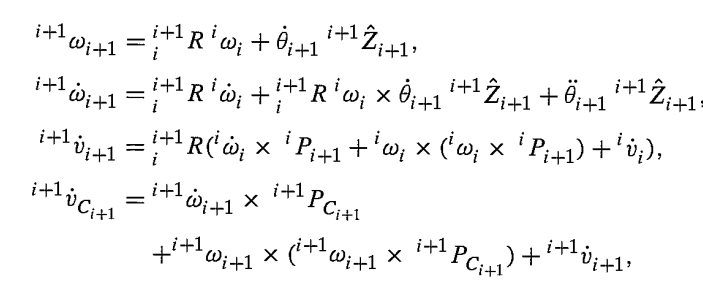

- Calculate inertial force & torque acting at the center of mass of each link (Newton's & Euler's equations):

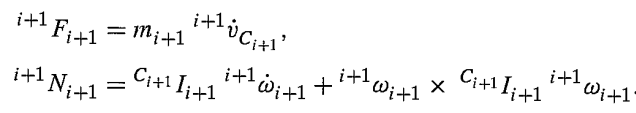

2. **Inward iterations** $i: 4 \rightarrow 1$:
- Calculate forces and torques of interaction and joint actuator torques:

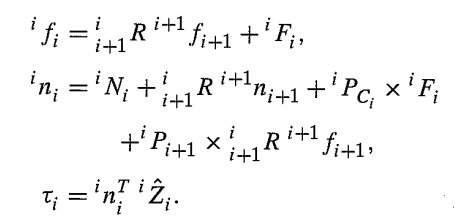